# Demo Convolutional Neural Network

### 4/20/2022

Upon request, here is a quick demo on creating a neural network using pytorch, and storing and deploying that model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
%config Completer.use_jedi = False


# Overview

We're going to use pytorch to build a CNN classifier from real data. I'll spell out the steps here along with the code. Please note that maintaining code in a notebook is bad practice, and that the real code will be stored in associated python files.

To start, I grabbed some free data from kaggle using keras' opendata framework. This API is particularly tricky, so I've attached the saved data with this repo as well. If you repeat these steps from scratch, you'll find that I did some manual adjustements to the file structure to make test/train splits easier.

Once we get the actual data, I'll show you how to upsample data using transformations. The idea here is to prevent overfitting by training the model on a number of different rotations and "flips" of the data. A really bad model might correctly identify a picture as a cat, but fail on the same photo rotated by 10&deg; and flipped horizontally. This transform step aims to alieviate that.

Afterwards I'll show you how to build a model class using pytorch. It's both more and less complicated than it looks, so we'll talk about it in person.


In [2]:
## let's mess with real data
import os
from PIL import Image #pillow library
from IPython.display import display

## pillow launches a crap ton of errors, so we're going to disable that
import warnings
warnings.filterwarnings('ignore')

## we'll grab some data from kaggle using keras' opendata framework
# import opendatasets as od

## downloading data
# but you can get this on your own
# od.download("https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip")
# od.download("https://www.kaggle.com/competitions/dogs-vs-cats/data?select=test1.zip")


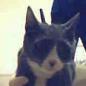

UwU


In [3]:
# check full filepath
with Image.open('../datasets/dogs-vs-cats/test/CAT/10107.jpg') as im:
    display(im)
print('UwU')

I honestly got these normalization transformations from other people on Kaggle. If you're lucky, you can use normalization vectors used by previous research. If none exist, I would stick with the tried-and-true method of z-scoring the data to means of 0 and standard deviations of 1.

This transformer acts as a pipeline generator function. All images are passed through this function before being read into the model.

In [7]:
norm_dict = {'mean':[.485, .456, .406], 'std':[.229, .224, .225]}
train_transform = transforms.Compose([
            transforms.RandomRotation(10), #randomly jitter by +/- 10 deg
            transforms.RandomHorizontalFlip(.5), #default .5 probability
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(**norm_dict) 
        ])

In [8]:
train_transform

Compose(
    RandomRotation(degrees=(-10, 10), resample=False, expand=False)
    RandomHorizontalFlip(p=0.5)
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Building the model class

pytorch works differently than the scikit-learn methods many of you are used to. We want to take full advantage of python's class objects to store data which can be operated on by functions within the class. To do this, we'll inheret the torch.nn.Module class as a way of adopting all of the pytorch presets.

In [9]:
import os
from torchvision import models
import time

class CNN(nn.Module):
    """
    Class wrapper for a pytorch convolutional neural network (CNN)
    This is primarially for example, and as such hyperparamers and network shape have been
    predefined based off of a random solution I found combing Kaggle back in the day (the
    exact entry is lost to time, I'm afraid). In practice, we'd perform a search for net
    size before deciding on a key winner. I have made notes on how the jump from convlutional
    to linear layers works mathematically
    """
    
    
    def __init__(self):
        """
        Constructor. Network connections are preset. Improvements to this model would 
        incorporate configurable nodes. Note that you can edit the model architecture via 
        the class, e.g.
        
        cnn = CNN()
        cnn.conv2 = nn.Conv2d(6, 24, 5, 1)
        #6 inputs, 24 output, 5x5 filter, 1 stride
        """
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1) #3 inputs, 6 output filters, 3x3 filter, stride of 1
        self.conv2 = nn.Conv2d(6, 16, 3, 1) #6 inputs, 16 output, 3x3 filter, 1 stride
        # 224 image -2 for border clipping / 2 for 2x2 pooling layer -2 for border clipping / 2 for 2x2 pooling
        # np.floor((((224 - 2)/2)-2)/2)
        # pixels per side calculation
        # it's square, and coming through an output of 16 filters
        # so 54*54*16
        self.fc1 = nn.Linear(54*54*16, 120) #outputing to 120 as an arbitrary param
        self.fc2 = nn.Linear(120, 84) # 84 nodes output is arbitrary
        self.fc3 = nn.Linear(84, 2) #two possible choices; should probably expand for better results
        
        
    def forward(self, X):
        """
        Forward movement through network for compatable input. 
        Loss and backpropogation to be defined outside this class.
        """
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) #technically multiclass but with only two classes


# Constructing the specific classifier class object

Now that we built a CNN to our specifications, I'm going to build a separate class that inherets the properties of that `CNN`, but includes project-specific functions for retrieving data, building a model, and saving that model. This technically isn't necessary for this demo, but when doing real-life models it's useful to be as modular as possible. You can think of `CatDog` as one of many potential experiments we might run on the `CNN` module project.

In [10]:
class CatDog(CNN):
    """
    Master class for retrieving data and running a convolutional neural network (CNN)
    """
    
    
    def __init__(self,datapath=None, manual_seed=12345):
        """
        constructor
        """
        super().__init__()
        if not datapath:
            self.datapath = '../datasets/dogs-vs-cats'
        self.trainpath = self.datapath + '/train'
        self.testpath = self.datapath + '/test'
        
        self.manual_seed = manual_seed
            
        
    def get_data(self, **kwargs):
        """
        Master function for retrieving data from the datapath specified in the constructor.
        Transforms data according to specified kwargs and conducts test/train splits.
        
        Parameters
        ----------
        **kwargs : see documentation for get_trainsforms        
        """
        img_files = self.get_data_files()
        self.img_files, self.img_sizes, self.rejected =  self._check_dimensions(img_files)
        
        self.train_transform, self.test_transform = self.get_transforms(self.img_files, **kwargs)
        self.train_data, self.test_data, self.train_loader, self.test_loader = self.split_data(self.datapath,
                                                                                          self.train_transform,
                                                                                          self.test_transform)
        self.class_names = self.train_data.classes
    
    
    def split_data(self, datapath, train_transform, test_transform):
        """
        Utility function for dividing data into test and train splits
        
        Parameters
        ----------
        datapath : str
            relative location of parent directory containing data
        train_transform : torchvision.transforms object for training data
        test_transform : torchvision.transforms object for training data
        
        Returns
        -------
        train_data : nn.Tensor
        
        """

        train_data = datasets.ImageFolder(os.path.join(datapath, 'train'), transform=train_transform)
        test_data = datasets.ImageFolder(os.path.join(datapath, 'test'), transform=test_transform)

        train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=10)
        
        return train_data, test_data, train_loader, test_loader

#     class_names = train_data.classes
        
        
    def get_transforms(self, 
                       img_files,  
                       rotation=10, 
                       flip=.5,
                       resize=224,
                       norm_dict=None
                      ):
        """
        
        """
        if not norm_dict:
            #arrays for all filters. these are taken from a sample network
            norm_dict = {'mean':[.485, .456, .406], 'std':[.229, .224, .225]}
            
        #defining our transforms
        train_transform = transforms.Compose([
            transforms.RandomRotation(rotation), #randomly jitter by +/- 10 deg
            transforms.RandomHorizontalFlip(flip), #default .5 probability
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(**norm_dict) 
        ])
        
        # transform test set to match dimensions (but not flipping or rotation)
        test_transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(**norm_dict) #arrays for all filters. these are taken from a sample network
        ])
        
        return train_transform, test_transform
        
    
    def get_data_files(self):
        """
        retrieve all paths to files used in training and analysis
        """
        path = self.datapath
        img_files = []

        for folder, subfolders, filenames in os.walk(path):
            for img in filenames:
                img_files.append(folder+'/'+img)
        return img_files
        
    
    def _check_dimensions(self, img_files):
        """
        utility function for checking images in filepaths,
        validating that they existing, and geting dimensions
        """
        img_sizes = []
        rejected = []

        for item in img_files:
            #get dimensions of all files
            try:
                with Image.open(item) as img:
                    img_sizes.append(img.size)
            #just in case no file exists
            except:
                rejected.append(item)
        
        if len(rejected):
            print(f'NO FILES FOUND:\n {rejected}')
            img_files = [i for i in img_files if i not in rejected]
        
        return img_files, img_sizes, rejected

    def display_images(self, images, nrow=5, inverse=True):
        """
        utility function for displaying a number of images for review
        
        Parameters
        ----------
        images : 3-dimensional tensors
            images to be viewed
        nrow : int
            number of images to display per row
        inverse : bool
            if True, inverts images to be viewed as before transformation
            if False, displays transformed images
        
        """
    
        im = make_grid(images, nrow=nrow)

        if inverse:

            trnf = self.train_transform.transforms[-1]
            inv_mean = -np.array(trnf.mean)/np.array(trnf.std)
            inv_std = 1/np.array(trnf.std)

            inv_normalize = transforms.Normalize(
                mean=inv_mean,
                std=inv_std
            )

            im = inv_normalize(im)

        plt.figure(figsize=(12,4))
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


        
    def prep_CNN(self, learning_rate=0.001, retrain=False):
        """
        establishes baseline parameters for running model. Optional parameter for
        retraining a model from current state rather than starting from scratch
        
        Parameters
        ----------
        learning_rate : float
            learning rate for optimizer step function in gradient descent
        retrain : bool
            if True, continues with existing parameters from prior model training.
            Note: will fail if prior model has not been trained
            if False, trains model from scratch
        
        Returns
        -------
        model : pytorch module object
        criterion : pytorch.nn loss criterion
        optimizer : pytorch.optim function (Adam optimizer)
        """
        if not retrain:
            torch.manual_seed(self.manual_seed)
            model = CNN()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        else:
            return self.model, self.criterion, self.optimizer
        
        return model, criterion, optimizer
    
        
    def train_CNN(self, learning_rate=.001, epochs=3, batch_limits=(800,300), retrain=False, save_as=None):
        """
        Big loop for training CNN according to set parameters. Trained model can be accessed through
        class object.
        
        Parameters
        ----------
        learning_rate : float
            learning rate for optimizer step function in gradient descent
        batch_limits : tuple, dim(2,2)
            for training purposes, limit the size of batches. If you're running this off a laptop,
            this is necessary to prevent this from taking 36 hours.
        retrain : bool
            if True, continues with existing parameters from prior model training.
            Note: will fail if prior model has not been trained
            if False, trains model from scratch
        save_as : None or str
            if not None, saves model to pickle file as `save_as`
        """
        
        self.model, criterion, optimizer = self.prep_CNN(learning_rate, retrain=retrain)
        
        start_time = time.time()

        #OPTIONAL TO REDUCE TRAINING TIME
        if batch_limits:
            #limiting number of training and testing batches for speed of demo
            max_trn_batch, max_tst_batch = batch_limits
        else:
            max_trn_batch = max_tst_batch = -1

        train_losses = []
        test_losses = []
        
        train_ns = []
        test_ns = []
        
        train_correct = []
        test_correct = []

        for i in range(epochs):
            trn_corr = 0
            tst_corr = 0
            batch_n = 0
            tst_n = 0

            for b, (X_train, y_train) in enumerate(self.train_loader):

                # optional: limit number of batches
                if b == max_trn_batch:
                    break
                    
                y_pred = self.model(X_train)
                loss = criterion(y_pred, y_train)

                #tracking predictions
                predicted = torch.max(y_pred.data, 1)[1]
                batch_corr = (predicted == y_train).sum()
                trn_corr += batch_corr
                batch_n += len(predicted)

                #update params
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if b%200== 0:
                    print(f'Epoch: {i+1} Batch: {b+1} Loss: {loss.item()}')

            train_losses.append(loss)
            train_correct.append(trn_corr)
            train_ns.append(batch_n)

            #test set!

            with torch.no_grad():
                for b, (X_test, y_test) in enumerate(self.test_loader):
                    # optional to save time during training
                    if b==max_tst_batch:
                        break

                y_val = self.model(X_test)

                predicted = torch.max(y_pred.data, 1)[1]
                batch_corr = (predicted == y_test).sum()

                tst_corr = tst_corr + batch_corr
                tst_n = tst_n + len(y_test)

            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)
            test_ns.append(tst_n)


        total_time = time.time() - start_time
        print(f'Total Time: {total_time/60} minutes')
        
        if save_as:
            self.save_model(save_as)
        
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.test_losses = test_losses
        self.test_correct = test_correct
        self.test_ns = test_ns
        
        self.train_losses = train_losses
        self.train_correct = train_correct
        self.train_ns = train_ns

        
    def save_model(self, save_as):
        """
        utility function to save model state dictionary in pickle format
        """
        torch.save(self.model.state_dict(), save_as)
    
    
    def get_model_accuracy(self, plot=True):
        """
        get model performance metrics for the train/test splits
        
        Parameters
        ----------
        plot : Bool
            toggle plot display
        """
        self.train_acc = np.array(self.train_correct) / np.array(self.train_ns)
        self.test_acc = np.array(self.test_correct) / np.array(self.test_ns)
        if plot:
            self.plot_model_accuracy()
        
        print(f'Final model performance:\n\t train: {self.train_acc[-1]}\t\n test:  {self.test_acc[-1]}')
    
    
    def plot_model_accuracy(self):
        """
        utility function to plot accuracy results
        """
        plt.figure(figsize = (8,4));
        plt.plot(np.arange(len(self.train_acc)), self.train_acc, label='train');
        plt.plot(np.arange(len(self.test_acc)), self.test_acc, label='test');
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
        plt.xticks(np.arange(len(self.test_acc)));
        plt.show();

        
    def load_model(self, model_path):
        """
        utility function to load model from path
        """
        self.load_state_dict(torch.load(model_path))
        print('loading saved state dictionary')
        print(m.eval())
        
        
    def predict(self, images):        
        """
        take transformed data and predict against stored model
        
        Parameters
        ----------
        images : torch.Tensor
            tensor of images to predict
            assumes proper transformations have been applied
        
        Returns
        -------
        y_hat : torch.Tensor
            tensor of binary predictions
        """
        y_pred = self.model(images)
        return torch.max(y_pred.data, 1)[1]
        
    
    def accuracy_score(self, y_hat, labels):
        """
        Utility function for scoring accuracy
        """
        correct = (y_hat == labels).sum()    
        return np.array(correct) / len(labels)


# Training the Model

Like I said, in real life you'd have this saved to a repo. We'll work form that.

In [5]:
import sys
sys.path.insert(1, '../mlex')

import pet_cnn

In [7]:
cd = pet_cnn.CatDog()

In [8]:
cd.get_data()

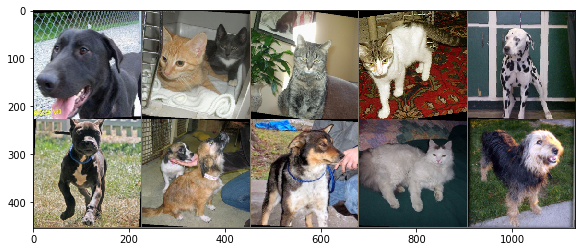

In [9]:
# getting some images from the loader. We set the loader to 10 images per batch
for images, labels in cd.train_loader:
    break
cd.display_images(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


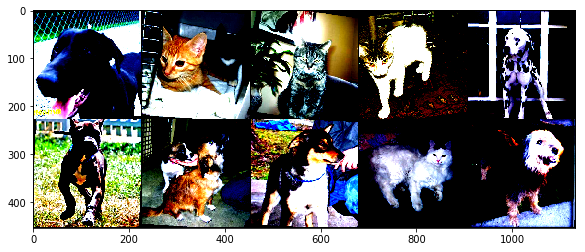

In [10]:
# showing what happens iif we don't inverse the images
# note the rotations!
cd.display_images(images, inverse=False)

In [11]:
# train the model
cd.train_CNN(epochs=5, batch_limits=(800, 300))

Epoch: 1 Batch: 1 Loss: 0.6951465606689453
Epoch: 1 Batch: 201 Loss: 0.6132767200469971
Epoch: 1 Batch: 401 Loss: 0.6754834055900574
Epoch: 1 Batch: 601 Loss: 0.961203932762146
Epoch: 2 Batch: 1 Loss: 0.592896580696106
Epoch: 2 Batch: 201 Loss: 0.614582896232605
Epoch: 2 Batch: 401 Loss: 0.802177906036377
Epoch: 2 Batch: 601 Loss: 0.5746608376502991
Epoch: 3 Batch: 1 Loss: 0.36336550116539
Epoch: 3 Batch: 201 Loss: 0.4430813789367676
Epoch: 3 Batch: 401 Loss: 0.5154402852058411
Epoch: 3 Batch: 601 Loss: 0.5354015827178955
Epoch: 4 Batch: 1 Loss: 0.5480309724807739
Epoch: 4 Batch: 201 Loss: 0.4102764129638672
Epoch: 4 Batch: 401 Loss: 0.4173380732536316
Epoch: 4 Batch: 601 Loss: 0.38599321246147156
Epoch: 5 Batch: 1 Loss: 0.6285780668258667
Epoch: 5 Batch: 201 Loss: 0.7034898996353149
Epoch: 5 Batch: 401 Loss: 0.23254218697547913
Epoch: 5 Batch: 601 Loss: 0.5898882746696472
Total Time: 18.917655118306477 minutes


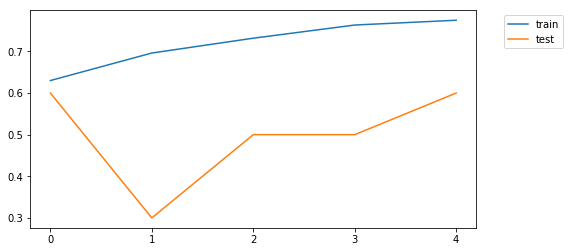

Final model performance:
	 train: 0.774875	
 test:  0.6


In [12]:
# display the model accuracy over time. 
# I'm honestly not quite sure what happened with the second round of testing
# but the upward trend says that we'll need several more epochs of training
# and also to remove the batch limits put in place for this demo
cd.get_model_accuracy(plot=True)

# Saving the model

In [13]:
cd.save_model('test_model')

# Reloading Model

In [21]:
import importlib
importlib.reload(pet_cnn)

<module 'pet_cnn' from '../mlex/pet_cnn.py'>

In [22]:
cd2 = pet_cnn.CatDog()
cd2.load_model('test_model')

loading saved state dictionary
CatDog(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
